In [1]:
#!pip install -U gensim

In [2]:
import pandas as pd ; import networkx as nx ; import ast ; import matplotlib.pyplot as plt ; import numpy as np ;
import nltk ; from wordcloud import WordCloud, ImageColorGenerator ; from PIL import Image ; import urllib.request ;
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS ; from collections import Counter

In [3]:
df_characters = pd.read_csv("https://raw.githubusercontent.com/ThomaSpyrou/SocialGraphsAss1/main/Final%20Project%20-%20Rick%20and%20Morty/df_characters_with_attr_and_communities.csv")
df_characters = df_characters.drop('Unnamed: 0', axis=1)
df_episodes = pd.read_csv('https://raw.githubusercontent.com/ThomaSpyrou/SocialGraphsAss1/main/Final%20Project%20-%20Rick%20and%20Morty/RaM_episodes.csv')
df_transcripts = pd.read_csv("https://raw.githubusercontent.com/ThomaSpyrou/SocialGraphsAss1/main/Final%20Project%20-%20Rick%20and%20Morty/transcripts/RickAndMortyScripts.csv")
df_nrc = pd.read_csv("https://raw.githubusercontent.com/ThomaSpyrou/SocialGraphsAss1/main/Final%20Project%20-%20Rick%20and%20Morty/NRC.csv")
df_nrc_01 = pd.read_csv('https://raw.githubusercontent.com/ThomaSpyrou/SocialGraphsAss1/main/Final%20Project%20-%20Rick%20and%20Morty/lexicons/NRC_sentiment_lexicon.csv')

In [4]:
df_transcripts["name"].replace({"Rick": "Rick Sanchez"}, inplace=True)
df_transcripts["name"].replace({"Evil Rick": "Evil Rick Sanchez"}, inplace=True)
df_transcripts["name"].replace({"Pickle Rick": "Pickle Rick (character)"}, inplace=True)
df_transcripts["name"].replace({"Morty": "Morty Smith"}, inplace=True)
df_transcripts["name"].replace({"Beth": "Beth Smith"}, inplace=True)
df_transcripts["name"].replace({"Jerry": "Jerry Smith"}, inplace=True)
df_transcripts["name"].replace({"Summer": "Summer Smith"}, inplace=True)

df_charLines = df_transcripts.groupby(['name'], as_index = False).agg({'line': ','.join})
df_charLines

,name,line
0,All,That's a fake-ass catchphrase right there.
1,'Rick D716-B,And I’d just like to say that prescription dru...
2,Abradolph Lincoler,"Rick, you brought me into this world, a suffer..."
3,Agency Director,"What is it?,Where is it?,We have 34 armed guar..."
4,Alan,I wish he had the ability to check is attitude...
...,...,...
416,Zeep,"I said 12 quantum stabilizers, not 11. Fix it ..."
417,Zigerion,"Sir, they're over the edge."
418,Zigerion 1,"Oh, god, sir! They're still naked! Ugh.,I thin..."
419,Zigerion 2,"Hey, man, Abductions just follows the acquisit..."


In [5]:
#Remove stopwords
df_charLines.line = df_charLines.line.apply(lambda x: remove_stopwords(x))

In [6]:
# Save as a csv
#df_charLines.to_csv('df_char_lines.csv', index=False)

In [7]:
characters_dialogue = df_charLines.set_index('name').T.to_dict('list') 

## NRC

In [8]:
from nltk.tokenize import RegexpTokenizer

def get_list_of_tokens(aSentence):
    """ Transform a sentence (string) into a list of tokens """
    # Set to lower case
    aSentence = aSentence.lower()
    # Tokenize
    tokens = RegexpTokenizer(r'\w+').tokenize(aSentence)
    # Lemmatize words
    tokens = [ nltk.WordNetLemmatizer().lemmatize(w) for w in tokens ]
    return tokens



def get_nrc_sentiment(aWord):
    """ Get the happiness average of a word from LabMT dictionary """
    #print(aWord)
    if (aWord in list(df_nrc.word)):
        sentiment = list(df_nrc.sentiment[df_nrc.word == aWord])
    else:    
        sentiment = []
    return sentiment    

def flatten(t):
    return [item for sublist in t for item in sublist]

def calculate_nrc_sentiments(aListOfTokens):
    """ Calculate the sentiments a list of tokens """
    sentiment_list = []
    if aListOfTokens != []:
        for aToken in aListOfTokens:
            sentiment = get_nrc_sentiment(aToken)
#            if sentiment != []:
#                sentiment_list.append(sentiment)    
            sentiment_list.extend(sentiment) 
    return Counter(sentiment_list)


In [9]:
# calculate the NRC sentiment score for each character

sentiment_NRC_list = []

def calculate_NRC_sentiment_of_a_node(aRow):
    if aRow.Name in list(characters_dialogue.keys()):
        sentiment_NRC_list.append([calculate_nrc_sentiments(get_list_of_tokens(aSentence)) for aSentence in characters_dialogue[aRow.Name]])
    else:
        sentiment_NRC_list.append(None)



_ = df_characters.apply(calculate_NRC_sentiment_of_a_node, axis=1)

# store in dataframe of characters as a new column
df_characters['NRC_score'] = sentiment_NRC_list
df_NRC = df_characters[df_characters.NRC_score.notnull()]

In [10]:
# pd.set_option('display.max_rows', 550)
# df_NRC.count()

### Sentiments per Character

In [11]:
def sort_dict(d):
    return {k: v for k, v in sorted(d.items(), key=lambda item: item[1], reverse = True)}

#d_Rick = sort_dict(df_NRC[df_NRC.Name == 'Rick Sanchez']['NRC_score'].tolist()[0][0])



def plot_character_sentiments(name):
    
    d = sort_dict(df_NRC[df_NRC.Name == name]['NRC_score'].tolist()[0][0])
    
    fig, ax = plt.subplots()
    sentiments = list(d.keys())
    y_pos = sentiments
    weight = list(d.values())
    ax.barh(y_pos, weight, align='center')
    ax.set_yticks(y_pos)   #, labels=sentiments
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Weight')
    ax.set_title('Sentiment Analysis: ' + name)
    plt.show()

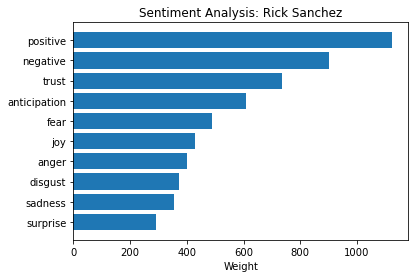

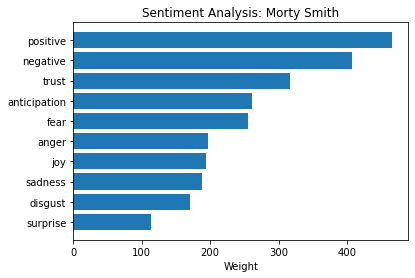

In [12]:
plot_character_sentiments('Rick Sanchez'), 
plot_character_sentiments('Morty Smith')

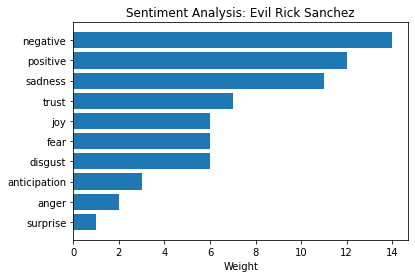

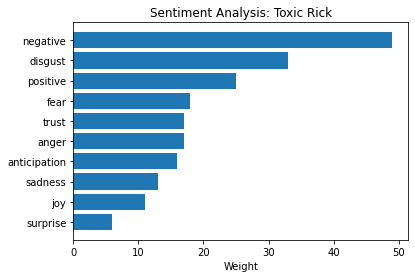

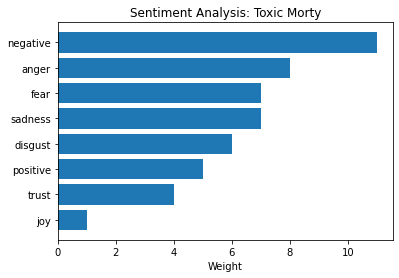

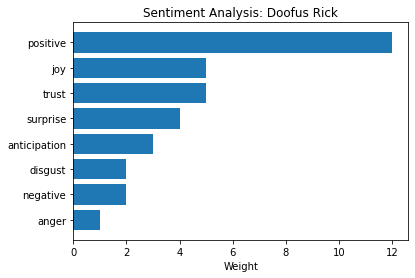

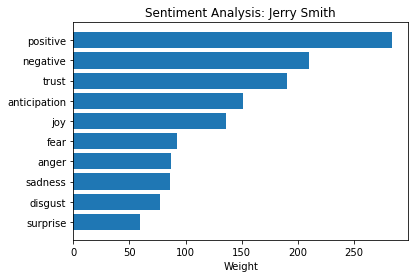

In [13]:
plot_character_sentiments('Evil Rick Sanchez'), 
plot_character_sentiments('Toxic Rick'),
plot_character_sentiments('Toxic Morty'),
plot_character_sentiments('Doofus Rick'),
plot_character_sentiments('Jerry Smith')

### Histogram per sentiment

In [14]:
sentiments_list = ['positive', 'negative', 'trust', 'anticipation', 'fear', 'joy', 'anger', 'disgust', 'sadness', 'surprise']

# for sentiment in sentiments_list:
#     count = 

# x = df_NRC[['NRC_score']].apply(lambda x: )


# plt.hist(df_LabMT.LabMT_score)
# plt.title("Anger in Rick and Morty")
# plt.xlabel("LabMT sentiment score")
# plt.ylabel("Count of characters")


####   I want to make a histogram with the sentiments and theis count in all dialogues 

### LabMT method

In [15]:
url_LabMT = "https://raw.githubusercontent.com/ThomaSpyrou/SocialGraphsAss1/main/Final%20Project%20-%20Rick%20and%20Morty/dataset_LabMT"

LabMT = urllib.request.urlopen(url_LabMT).read().decode('utf-8')
# remove the useless start of the text
LabMT = LabMT[172:]
# process text file for dictionary conversion
LabMT = LabMT.split('\n')
LabMT = [aList.split('\t') for aList in LabMT]
# create LabMT dictionary
LabMT_dict = {}
for aList in LabMT:
    if len(aList) == 8:
        aWord = aList[0]
        # we only take "happiness_average" in account here
        aHappinessAvg = float(aList[2])
        LabMT_dict[aWord]=aHappinessAvg

In [16]:
def get_list_of_tokens(aSentence):
    """ Transform a sentence (string) into a list of tokens """
    # Set to lower case
    aSentence = aSentence.lower()
    # Tokenize
    tokens = RegexpTokenizer(r'\w+').tokenize(aSentence)
    # Lemmatize words
    tokens = [ nltk.WordNetLemmatizer().lemmatize(w) for w in tokens ]
    return tokens

def get_happiness_average(aWord):
    """ Get the happiness average of a word from LabMT dictionary """
    if aWord in list(LabMT_dict.keys()) :
        return LabMT_dict[aWord]
    return None

def calculate_LabMT_sentiment(aListOfTokens):
    """ Calculate the sentiment score of a list of tokens """
    sentiment_score = 0
    if aListOfTokens != []:
        for aToken in aListOfTokens:
            anHapinessAvg = get_happiness_average(aToken)
            if anHapinessAvg != None:
                sentiment_score += anHapinessAvg
        return sentiment_score/len(aListOfTokens)
    return sentiment_score

In [17]:
# calculate the LabMT sentiment score for each character

sentiment_LabMT_score_list = []

def calculate_LabMT_sentiment_of_a_node(aRow):
    if aRow.Name in list(characters_dialogue.keys()):
        sentiment_LabMT_score_list.append(np.mean([calculate_LabMT_sentiment(get_list_of_tokens(aSentence)) for aSentence in characters_dialogue[aRow.Name]]))
    else:
        sentiment_LabMT_score_list.append(None)

_ = df_characters.apply(calculate_LabMT_sentiment_of_a_node, axis=1)

In [18]:
# store in dataframe of characters as a new column
df_characters['LabMT_score']=sentiment_LabMT_score_list
df_LabMT = df_characters[df_characters.LabMT_score.notnull()]

### VADER Method

In [19]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# calculate the VADER sentiment score for each character

analyzer = SentimentIntensityAnalyzer()

vader_score_list = []

def calculate_VADER_of_a_node(aRow):
    if aRow.Name in list(characters_dialogue.keys()):
        vader_score_list.append(np.mean([analyzer.polarity_scores(aSentence)['compound'] for aSentence in characters_dialogue[aRow.Name]]))
    else:
        vader_score_list.append(None)

_ = df_characters.apply(calculate_VADER_of_a_node, axis=1)

In [20]:
# store in dataframe of characters as a new column
df_characters['VADER_score']=vader_score_list
df_VADER = df_characters[df_characters.VADER_score.notnull()]

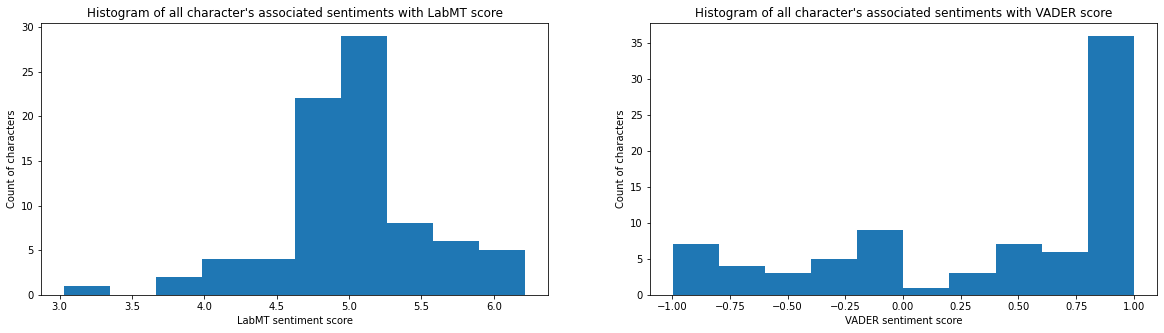

In [21]:
plt.figure(figsize=(20,5))

plt.subplot(121)
plt.hist(df_LabMT.LabMT_score)
plt.title("Histogram of all character's associated sentiments with LabMT score")
plt.xlabel("LabMT sentiment score")
plt.ylabel("Count of characters")

plt.subplot(122)
plt.hist(df_VADER.VADER_score)
plt.title("Histogram of all character's associated sentiments with VADER score")
plt.xlabel("VADER sentiment score")
plt.ylabel("Count of characters")
plt.show()

df_transcripts

In [22]:
def print_characters_with_score(a10DataFrame, typeOfScore):
    i=1
    for index, row in a10DataFrame.iterrows():
        print("{}. {} ({})".format(i, row.Name, round(row[typeOfScore],2)))
        i+=1

In [23]:
ten_happiest_characters_LabMT = df_LabMT.sort_values('LabMT_score', ascending=False).head(10)
ten_saddest_characters_LabMT = df_LabMT.sort_values('LabMT_score', ascending=True).head(10)

ten_happiest_characters_VADER = df_VADER.sort_values('VADER_score', ascending=False).head(10)
ten_saddest_characters_VADER = df_VADER.sort_values('VADER_score', ascending=True).head(10)

print("10 happiest characters with LabMT method are:")
print_characters_with_score(ten_happiest_characters_LabMT, 'LabMT_score' )
print("\n10 happiest characters with VADER method are:")
print_characters_with_score(ten_happiest_characters_VADER, 'VADER_score' )
print("\n10 saddest characters with LabMT method are:")
print_characters_with_score(ten_saddest_characters_LabMT, 'LabMT_score')
print("\n10 saddest characters with VADER method are:")
print_characters_with_score(ten_saddest_characters_VADER, 'VADER_score')

10 happiest characters with LabMT method are:
1. Mechanical Rick (6.22)
2. Ruben (6.15)
3. Steven Phillips (6.11)
4. Johnny Depp (5.96)
5. Mechanical Summer (5.93)
6. Baby Legs (5.77)
7. Ethan (5.73)
8. Regular Legs (5.73)
9. Slow Mobius (5.68)
10. Tinkles (5.63)

10 happiest characters with VADER method are:
1. Jerry Smith (1.0)
2. Rick Sanchez (1.0)
3. Morty Smith (1.0)
4. Beth Smith (1.0)
5. Principal Vagina (1.0)
6. Summer Smith (1.0)
7. Doofus Rick (1.0)
8. Unity (0.99)
9. Mr. Goldenfold (0.99)
10. Mechanical Morty (0.99)

10 saddest characters with LabMT method are:
1. Pussifer (3.03)
2. Mr. Booby Buyer (3.78)
3. Cynthia (3.98)
4. Colossus (3.99)
5. Evil Morty (4.0)
6. Alexander (4.06)
7. Roy (4.19)
8. Kevin (4.42)
9. Squanchy (4.47)
10. Riq IV (4.56)

10 saddest characters with VADER method are:
1. Toxic Rick (-1.0)
2. Toxic Morty (-0.98)
3. Evil Rick Sanchez (-0.97)
4. Scary Terry (-0.94)
5. Kyle (-0.91)
6. The President (-0.9)
7. Blim Blam (-0.82)
8. Ron Benson (-0.74)
9. Krom

In [24]:
#happiest_Ricks
#saddest Ricks

In [25]:
df_charLines = df_transcripts.groupby(['name'], as_index = False).agg({'line': ','.join})
df_charLines

,name,line
0,All,That's a fake-ass catchphrase right there.
1,'Rick D716-B,And I’d just like to say that prescription dru...
2,Abradolph Lincoler,"Rick, you brought me into this world, a suffer..."
3,Agency Director,"What is it?,Where is it?,We have 34 armed guar..."
4,Alan,I wish he had the ability to check is attitude...
...,...,...
416,Zeep,"I said 12 quantum stabilizers, not 11. Fix it ..."
417,Zigerion,"Sir, they're over the edge."
418,Zigerion 1,"Oh, god, sir! They're still naked! Ugh.,I thin..."
419,Zigerion 2,"Hey, man, Abductions just follows the acquisit..."
